# Computer Vision - Image recognition via Deep Learning

## Project's objective

Identify handwritten digits with the highest accuracy possible.

## Data

The data used for this project comes from the MNIST dataset which is a very good basis for people who want to try learning techniques and pattern recognition method on real-world data.

The data contains contains 70,000 instances of labeled images (28x28 pixels) representing handwritten digits going from 0 to 9.

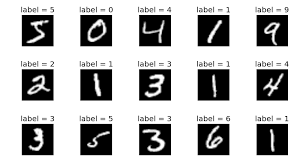

These image-label pairs are divided into 60,000 training examples and 10,000 testing examples.

## Methodology

For this project, the classification problem is tackled via Supervised Deep Learning. 
First of all, a data pre-processing step will be performed to explore the MNIST dataset and prepare data for analysis via encoding, formatting, and normalizing.
Then, two neural networks will be built: 

* Multi-Layer Perceptron (MLP)
* Convolutional Neural Network (CNN)

Models' hyperparameters configuration will be tuned to maximize performances while preventing classic issues such as overfitting. 
Results will be finally compared to identify which model yields the highest accuracy.

# Modules Import

In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data pre-processing

In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist

In [3]:
print('Loading data...')
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

Loading data...


In [4]:
s1 = pd.Series(mnist_train_labels).value_counts()
s2 = pd.Series(mnist_test_labels).value_counts()
overview = pd.concat([s1.rename('Train data'), s2.rename('Test data')], axis=1)
overview

,Train data,Test data
0,5923,980
1,6742,1135
2,5958,1032
3,6131,1010
4,5842,982
5,5421,892
6,5918,958
7,6265,1028
8,5851,974
9,5949,1009


In [5]:
mnist_train_images[298]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  49, 125, 168, 254, 254,
        254, 254, 160,  38,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

Data pre-processing steps:

1. One-hot encoding - labels converted into one-hot format (optimal format for classification models to handle labels over training). 


2. Reshaping images - depending on the model used: 

==> MLP: flat arrays of 784 values.

==> CNN: keep image size of 28x28 pixels and add channel color value "1" consistently (depending on the Keras data format set up). N.B: as images are just in grayscale here, there is one single color channel ("1"). If we were dealing with color images, we'd have three color channels (red, green and blue). 

3. Normalization - convert images values into floating points and normalize. 

In [6]:
# MLP data pre-processing

def process_MLP(train_images, train_labels, test_images, test_labels):
    
    # Labels one-hot encoding
    train_labels = tensorflow.keras.utils.to_categorical(train_labels, 10)
    test_labels = tensorflow.keras.utils.to_categorical(test_labels, 10)
    
    # Flatten 28x28 images into 784 values arrays
    train_images = train_images.reshape(60000, 784)
    test_images = test_images.reshape(10000, 784)
    
    # Normalization
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    train_images /= 255
    test_images /= 255
    
    return train_images, train_labels, test_images, test_labels

In [7]:
# CNN data pre-processing

def process_CNN(train_images, train_labels, test_images, test_labels):
    
    # Labels one-hot encoding
    train_labels = tensorflow.keras.utils.to_categorical(mnist_train_labels, 10)
    test_labels = tensorflow.keras.utils.to_categorical(mnist_test_labels, 10)
    
    # Add chanel color value "1", depending on the Keras data format set up 
    if K.image_data_format() == 'channels_first':
        train_images = train_images.reshape(mnist_train_images.shape[0], 1, 28, 28)
        test_images = test_images.reshape(mnist_test_images.shape[0], 1, 28, 28)
        input_shape = (1, 28, 28)
    else:
        train_images = mnist_train_images.reshape(train_images.shape[0], 28, 28, 1)
        test_images = mnist_test_images.reshape(test_images.shape[0], 28, 28, 1)
        input_shape = (28, 28, 1)
        
    # Normalization
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    train_images /= 255
    test_images /= 255
    
    return train_images, train_labels, test_images, test_labels, input_shape

As a sanity check, let's print out one of the training example with its label. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


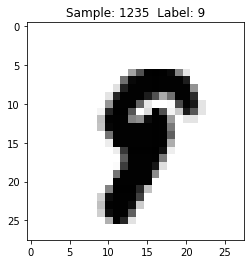

In [8]:
train_images, train_labels, test_images, test_labels = process_MLP(mnist_train_images, mnist_train_labels, 
                                                                   mnist_test_images, mnist_test_labels)

def display_sample(train_images, train_labels, num):
    # Print the one-hot array of this sample's label 
    print(train_labels[num])  
    # Print the image and label converted back to a number
    image = train_images[num].reshape([28,28])
    label = train_labels[num].argmax(axis=0)
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(train_images, train_labels, 1235)

# Multi-Layer Perceptron (MLP)

Network topology:

* Input layer - 784 features feeds into a ReLU layer of 512 units
* Dropout - apply dropout filter to prevent overfitting.
* Hidden layer (optional) - ReLU layer of 128 units
* Output layer - 10 units with softmax applied to choose our category of 0-9.

We will use the RMSProp optimizer here. Other choices include Adagrad, SGD, Adam, Adamax, and Nadam. See https://keras.io/optimizers/

In [9]:
def MLP():
    model = Sequential()
    # Input layer
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    # Dropout
    model.add(Dropout(0.5))
    # Hidden layer (turns out to be inefficient)
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    return model

model = MLP()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Let's train our MLP on 10 epochs with batch size of 100. 

In [10]:
# Data pre-processing
train_images, train_labels, test_images, test_labels = process_MLP(mnist_train_images, mnist_train_labels, 
                                                                   mnist_test_images, mnist_test_labels)

In [11]:
history = model.fit(train_images, train_labels,
                    batch_size=100,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/10
600/600 - 7s - loss: 0.2822 - accuracy: 0.9134 - val_loss: 0.1127 - val_accuracy: 0.9650
Epoch 2/10
600/600 - 6s - loss: 0.1415 - accuracy: 0.9578 - val_loss: 0.0948 - val_accuracy: 0.9738
Epoch 3/10
600/600 - 7s - loss: 0.1167 - accuracy: 0.9651 - val_loss: 0.0800 - val_accuracy: 0.9775
Epoch 4/10
600/600 - 7s - loss: 0.1006 - accuracy: 0.9702 - val_loss: 0.0763 - val_accuracy: 0.9792
Epoch 5/10
600/600 - 8s - loss: 0.0928 - accuracy: 0.9739 - val_loss: 0.0691 - val_accuracy: 0.9814
Epoch 6/10
600/600 - 8s - loss: 0.0847 - accuracy: 0.9764 - val_loss: 0.0682 - val_accuracy: 0.9801
Epoch 7/10
600/600 - 7s - loss: 0.0786 - accuracy: 0.9779 - val_loss: 0.0852 - val_accuracy: 0.9785
Epoch 8/10
600/600 - 6s - loss: 0.0743 - accuracy: 0.9796 - val_loss: 0.0690 - val_accuracy: 0.9828
Epoch 9/10
600/600 - 7s - loss: 0.0719 - accuracy: 0.9804 - val_loss: 0.0765 - val_accuracy: 0.9809
Epoch 10/10
600/600 - 6s - loss: 0.0689 - accuracy: 0.9813 - val_loss: 0.0758 - val_accuracy: 0.9820

In [12]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

scores = pd.DataFrame(columns=['Model', 'Score'])
scores.loc[0] = ['Multi-Layer Perceptron', score[1]]
scores

Test loss: 0.0757911279797554
Test accuracy: 0.9819999933242798


,Model,Score
0,Multi-Layer Perceptron,0.982


# Convolutional Neural Network (CNN)

Setting up a convolutional neural network involves more layers. Not all of these are strictly necessary (eg. pooling and dropout) but those extra steps help avoid overfitting and run operations faster).

Network topology:

* Convolution 1 - 2D convolution of the image (set up to take 32 windows/filters of each image, each filter being 3x3 in size).

* Convolution 2 - second convolution on top of that with 64 3x3 windows - this topology is just what comes recommended within Keras's own examples. Again you want to re-use previous research whenever possible while tuning CNN's, as it is hard to do.

* Pooling - apply a MaxPooling2D layer that takes the maximum of each 2x2 result to distill the results down into something more manageable.

* Dropout - apply dropout filter to prevent overfitting.

* Flatten layer - flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron...

* Hidden layer - feed results into a hidden, flat layer of 128 units.

* Dropout - apply dropout again to further prevent overfitting.

* Output layer - feed results into a final 10 units layer where softmax is applied. 

This time, we use the Adam optimizer.  

In [13]:
train_images, train_labels, test_images, test_labels, input_shape = process_CNN(mnist_train_images, mnist_train_labels, 
                                                                                mnist_test_images, mnist_test_labels)

In [14]:
def CNN(input_shape, optimizer):
    model = Sequential()
    # Convolution 1 - 32 3x3 kernels
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    # Convolution 2 - 64 3x3 kernels
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # Pooling - Reduce by taking the max of each 2x2 block
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dropout to avoid overfitting
    model.add(Dropout(0.25))
    # Flatten the results to one dimension 
    model.add(Flatten())
    # Hidden layer 
    model.add(Dense(128, activation='relu'))
    # Dropout
    model.add(Dropout(0.5))
    # Output layer - Final categorization from 0-9 with softmax
    model.add(Dense(10, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = CNN(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [15]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

scores.loc[len(scores)] = ['Convolutional Neural Network', score[1]]
scores

Epoch 1/10
1875/1875 - 90s - loss: 0.1967 - accuracy: 0.9411 - val_loss: 0.0421 - val_accuracy: 0.9870
Epoch 2/10
1875/1875 - 90s - loss: 0.0811 - accuracy: 0.9757 - val_loss: 0.0350 - val_accuracy: 0.9881
Epoch 3/10
1875/1875 - 94s - loss: 0.0639 - accuracy: 0.9805 - val_loss: 0.0315 - val_accuracy: 0.9892
Epoch 4/10
1875/1875 - 97s - loss: 0.0507 - accuracy: 0.9847 - val_loss: 0.0295 - val_accuracy: 0.9913
Epoch 5/10
1875/1875 - 91s - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.0308 - val_accuracy: 0.9899
Epoch 6/10
1875/1875 - 90s - loss: 0.0400 - accuracy: 0.9878 - val_loss: 0.0353 - val_accuracy: 0.9900
Epoch 7/10
1875/1875 - 95s - loss: 0.0351 - accuracy: 0.9891 - val_loss: 0.0269 - val_accuracy: 0.9914
Epoch 8/10
1875/1875 - 94s - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.0314 - val_accuracy: 0.9914
Epoch 9/10
1875/1875 - 83s - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.0311 - val_accuracy: 0.9921
Epoch 10/10
1875/1875 - 84s - loss: 0.0260 - accuracy: 0.9915 - val_loss:

In [18]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

scores.loc[1] = ['Convolutional Neural Network', score[1]]
scores

Test loss: 0.033878814429044724
Test accuracy: 0.9904000163078308


,Model,Score
0,Multi-Layer Perceptron,0.9820
1,Convolutional Neural Network,0.9904
2,Convolutional Neural Network,0.9904
